In [37]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

(sec:theory_measurementError)=
# Measurement Error: Air Quality Variation

Simulating the draw of marbles from an urn is a useful abstraction for studying the possible outcomes from survey samples and controlled experiments. Of course, this is only possible if a chance mechanism is used to select the sample or to assign the treatment. However in many settings, measurement error also follows a similar chance process. As mentioned in {numref}`sec:scope_construct`, instruments typically have an error associated with them, and by taking repeated measurements on the same object, we can quantify the variability associated with the instrument. However to detect bias in the instruments measurements, we need comparisons to a more accurate instrument or measurements on a standard that has a known value. For example, the International Bureau of Weights and Measures in Sèvres, France has kept a one kilogram cylinder of platinum since 1889 to calibrate instruments.

(In 2011, the definition of the kilogram changed to no longer rely on a physical object, and instead be defined by a physical constant—Planck's constant—because the standard in France was found to have lost 50 micrograms in comparison to other copies of the standard kilogram).  

As an example, we consider the variation in measurements of a PurpleAir sensor that measures air quality. PurpleAir provides a data download tool so anyone can access air quality measurements by interacting with their map. These data are available in 10-minute intervals for any sensor appearing on the map. To get a sense of the size of the variations in measurements for one sensor, we downloaded data for one sensor from a 36-hour period and selected four 30-minute periods (giving us three consecutive measurements) for a total of 12 measurements.  These are available in 'data/purpleAir30minsample.csv'.

In [38]:
pm = pd.read_csv('data/purpleAir30minsample.csv')
pm

,pm2.5,time
0,9.48,A
1,9.32,A
2,9.29,A
...,...,...
9,15.31,D
10,15.49,D
11,14.72,D


The feature `pm2.5` refers to the amount of particulate matter measured in the air that has a diameter smaller than 2.5 micrometers (the unit of measurement is micrograms per cubic meter: μg/m3). These measurements are 10-minute averages. The time periods are simply denoted, A, B, C, and D.

A scatter plot of the particulate matter measurements gives us a basic sense of variation in the instrument. In each time period, the measurements cluster together. For example, at time "C", the measurements are all about 12. We can also see in the plot that the level of particulate matter changes quite a bit over the course of a day, in comparison to the variability of the measurements taken close in time.

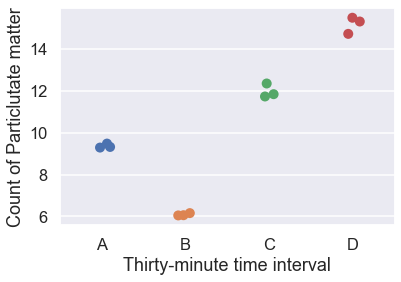

In [39]:
sns.stripplot(data=pm, x="time", y="pm2.5",  dodge=True, size=10)
plt.xlabel("Thirty-minute time interval")
plt.ylabel("Count of Particlutate matter");

We can get a sense of the variation in the instruments measurements by examining the variation of the individual measurements from the average of each time period. 

In [40]:
mean_time = pm.groupby('time')['pm2.5'].mean()
mean_time

time
A     9.36
B     6.09
C    11.97
D    15.17
Name: pm2.5, dtype: float64

In [41]:
errors = pm['pm2.5'] - (9.36, 9.36, 9.36, 6.09, 6.09, 6.09, 11.97, 11.97, 11.97, 15.17, 15.17, 15.17)

Text(0.5, 0, 'Deviation from Group Average')

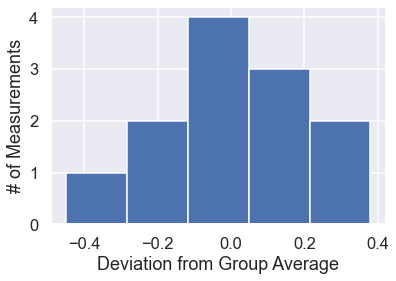

In [42]:
plt.hist(errors, bins=5)
plt.ylabel('# of Measurements')
plt.xlabel('Deviation from Group Average')

The histogram shows us that typical error for PM2.5 measurements from this instrument is about 0.25. Given the measurements range from 6 to 15, we find that the instrument is relatively accurate compared to the size of the typiucal measurements. Unfortunately, what we don't know is whether the measurements are cloase to the true air quality at that time and place. A more comprehensive analysis of the measurement error, including bias is addressed in {numref}`Chapter %s <ch:pa>`. The remainder of this chapter is dedicated to more formal treatment of these concepts using probability. We begin by tackling random sampling schemes.